In [ ]:
import torchvision
import cv2
import torch

#**Semantic Segmentation**

#1.FCN with resnet101

##1.load model and put it in inference mode

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##2.load image

2023-07-08 10:15:22 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


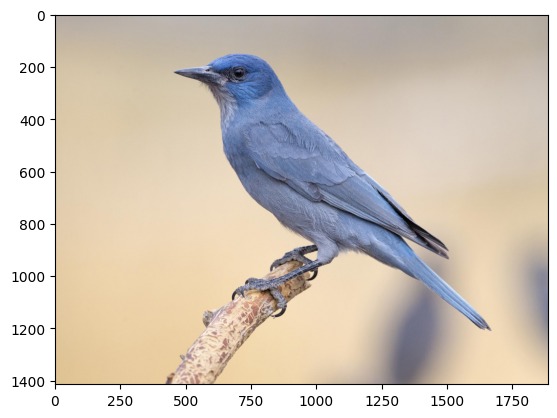

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img)
plt.show()

In [ ]:
img.size

(1885, 1414)

##3.Transform Image

In [ ]:
from torchvision import transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485,0.456,0.406],
                                    std=[0.229,0.224,0.225]
                                )])

In [ ]:
inp = transform(img).unsqueeze(0)
inp.shape

torch.Size([1, 3, 224, 224])

##4.Forward pass

In [ ]:
out = fcn(inp)['out']
out.shape

torch.Size([1, 21, 224, 224])

In [ ]:
out.squeeze().shape

torch.Size([21, 224, 224])

In [ ]:
#We take a max index for each pixel position, which represents the class.
import numpy as np
om = torch.argmax(out.squeeze(),dim=0).detach().cpu().numpy() #detach() method is used to create a new tensor that shares the same data with the original tensor (out.squeeze().argmax(dim=0)), but doesn't require gradients.
om.shape, np.unique(om)

((224, 224), array([0, 3]))

##5.Decode Output

In [ ]:
def decode_segmap(image,nc=21):
  #store color for each class
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
  #create RGB image from 2D image we have
  r = np.zeros_like(image).astype(np.uint8)#empty 2D matrix for R channel
  g = np.zeros_like(image).astype(np.uint8)#empty 2D matrix for G channel
  b = np.zeros_like(image).astype(np.uint8)#empty 2D matrix for B channel

  for l in range(0,nc):
    idx = image == l #obtain corresponding indexes in image where that particular class label is present

    #For each channel, we put its corresponding color to those pixels where that class label is present
    r[idx] = label_colors[l,0]
    g[idx] = label_colors[l,1]
    b[idx] = label_colors[l,2]

  rgb = np.stack([r,g,b],axis=2)#stack all channel to form a RGB image
  return rgb


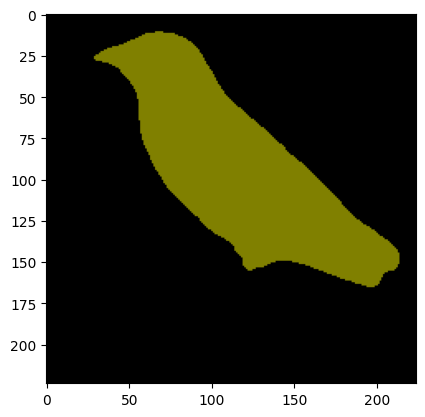

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb)
plt.show()

##All steps in one function

In [ ]:
def segment(net,path):
  #load image
  img = Image.open(path)
  plt.imshow(img); plt.axis('off');plt.show()

  #Transform image
  trf = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225]
                            )])
  inp = trf(img).unsqueeze(0)

  #Forward pass
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(),dim=0).detach().cpu().numpy()

  #Decode output
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off');plt.show()

In [ ]:
# new image
!wget -nv https://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png

2023-07-08 10:16:19 URL:https://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [128686/128686] -> "horse.png" [1]


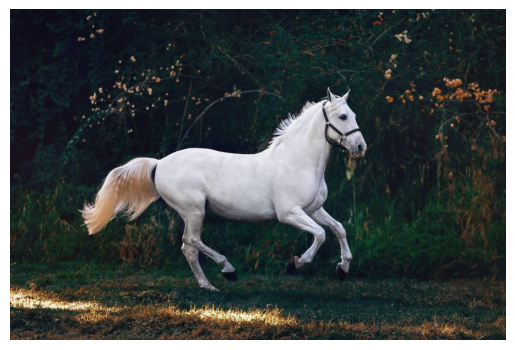

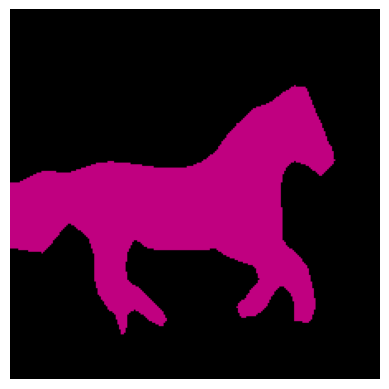

In [ ]:
path = './horse.png'
segment(fcn,path)

#2.DeepLab

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


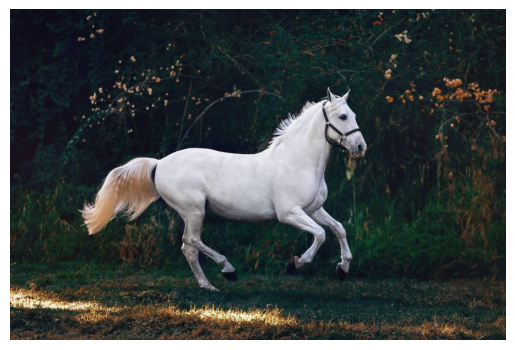

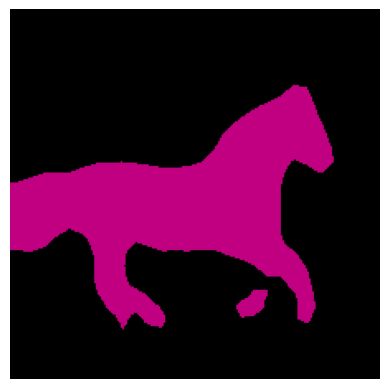

In [ ]:
segment(dlab,path)

#Some more example

2023-07-08 10:16:38 URL:https://learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg [95431/95431] -> "dog-park.png" [1]


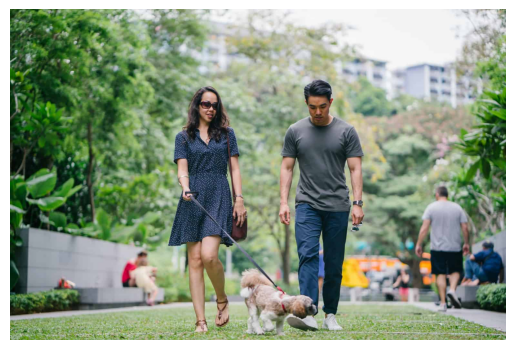

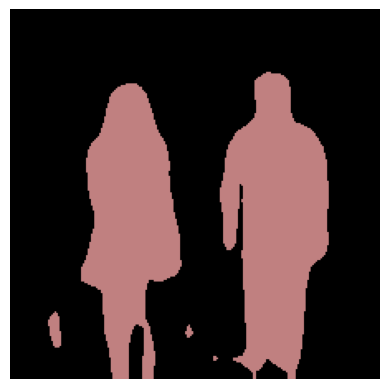

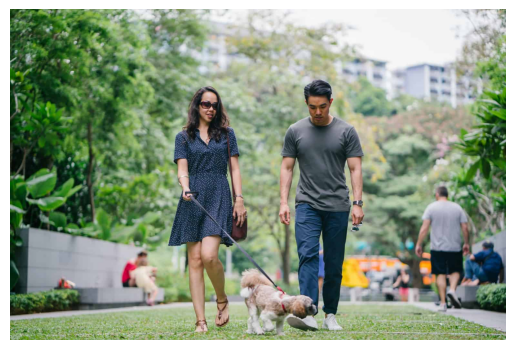

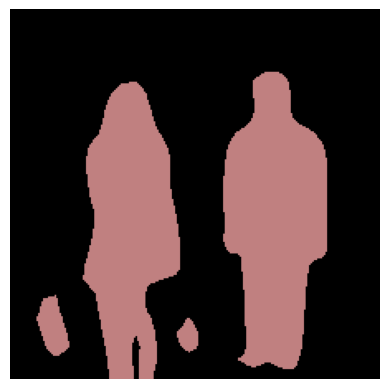

In [ ]:
!wget -nv "https://learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O dog-park.png

img = Image.open('./dog-park.png')
segment(fcn,'./dog-park.png')
segment(dlab,'./dog-park.png')

Note:
*      -Comment the Resize and CenterCrop for better inference results
*      -More RAM required